In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pickle
from torch.utils.data import Subset

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Hyperparameters

In [20]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.0002
BATCH_SIZE = 64
IMAGE_SIZE = 64
IMAGE_CHANNELS = 3
NUM_CLASSES = 10
EMBED_SIZE = 100
Z_DIM = 100
EPOCHS = 50
DISC_FEATURES = 64
GEN_FEATURES = 64

Download Images for Training

In [3]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = Dataset.CIFAR10('./data', download=True, train=True, transform=transform)
test = Dataset.CIFAR10('./data', download=True, train=False, 
                           transform=transform)
trainset=trainset+test

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


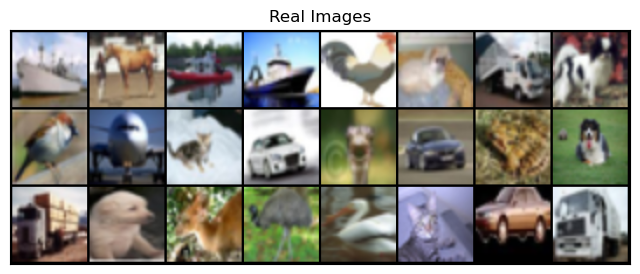

In [4]:
def imshow(imgs, title, figsize=(8,8), nrow=8):
    imgs = vutils.make_grid(imgs, nrow, normalize=True)
    imgs=imgs.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(imgs, (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()
    
images, labels = next(iter(trainloader))
imshow(images[:24], 'Real Images')

Generator & Discriminator

In [5]:
class Generator(nn.Module):
    def __init__(self, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM+embed_size, GEN_FEATURES*16, 4, 1, 0, bias=False), # 1024 x 4 x 4
            self._block(GEN_FEATURES*16, GEN_FEATURES*8, 4, 2, 1),           # 512 x 8 x 8
            self._block(GEN_FEATURES*8, GEN_FEATURES*4, 4, 2, 1),            # 256 x 16 x 16
            self._block(GEN_FEATURES*4, GEN_FEATURES*2, 4, 2, 1),            # 128 x 32 x 32
            nn.ConvTranspose2d(GEN_FEATURES*2, IMAGE_CHANNELS, 4, 2, 1),     # 64 x 64 x 64  #size. (n_channels) x 64 x 64
            nn.Tanh() )
        
        self.embed = nn.Embedding(num_classes, embed_size)
        
    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding, bias=False),
                             nn.BatchNorm2d(out_channels),
                             nn.ReLU() )
    
    def forward(self, z, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        z = torch.cat([z, embedding], dim=1) #batch_size x C x img_size(H) x img_size(W)
        return self.net(z)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            # input size: batch_size x 3 x 64 x 64
            nn.Conv2d(IMAGE_CHANNELS, DISC_FEATURES, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),                          # 64 x 32 x 32
            self._block(DISC_FEATURES, DISC_FEATURES*2, 4, 2, 1),     # 128 x 16 x 16
            self._block(DISC_FEATURES*2, DISC_FEATURES*4, 4, 2, 1),   # 256 x 8 x 8
            self._block(DISC_FEATURES*4, DISC_FEATURES*8, 4, 2, 1),   # 512 x 4 x 4
        )
        
        self.embed = nn.Embedding(num_classes, img_size*img_size)
        
        #input 512*4*4
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512,1,4,1,0,bias = False),
                                   nn.Sigmoid())
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
        )
        
        
    def _block(self, in_channels, out_channels, kernel, stride, padding):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel, stride, padding, bias=False),
                             nn.BatchNorm2d(out_channels),
                             nn.LeakyReLU(0.2),
                            )
    
    def forward(self, x):
        x= self.net(x)
        validity = self.validity_layer(x).view(-1)
        label = self.labels(x).view(-1, 11)
        return validity, label

In [7]:
def gradientPenalty(critic, labels, real, fake):
    batch_size, C, H, W = real.shape
    eps = torch.rand(batch_size, 1, 1, 1).repeat(1, C, H, W).to(device)
    interpolation = real*eps + fake*(1-eps)
    mixed_scores = critic(interpolation, labels)
    
    gradient = torch.autograd.grad(inputs=interpolation,
                                  outputs=mixed_scores,
                                  grad_outputs=torch.ones_like(mixed_scores),
                                  create_graph=True,
                                  retain_graph=True)[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [10]:
def weight_initialization(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
            
            
DiscModel =Discriminator(NUM_CLASSES, IMAGE_SIZE).to(device)
GenModel = Generator(NUM_CLASSES, IMAGE_SIZE, EMBED_SIZE).to(device)

#initialize weights for both models
DiscModel.apply(weight_initialization)
GenModel.apply(weight_initialization)

#Loss_function
criterion = nn.BCELoss()

disc_optim = optim.Adam(DiscModel.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
gen_optim = optim.Adam(GenModel.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

Training phase

In [13]:
import os

# Ensure the required directories exist
os.makedirs('Images/acganimages/real', exist_ok=True)
os.makedirs('Images/acganimages/fake', exist_ok=True)
os.makedirs('Models', exist_ok=True)
os.makedirs('pickle', exist_ok=True)


Starting Epoch [1/50]
[Epoch 1/50] Batch 0/938 | Loss_D: 2.0466 | Loss_G: 4.7588
[Epoch 1/50] Batch 100/938 | Loss_D: 1.4447 | Loss_G: 7.3479
[Epoch 1/50] Batch 200/938 | Loss_D: 1.3656 | Loss_G: 10.4667
[Epoch 1/50] Batch 300/938 | Loss_D: 1.2388 | Loss_G: 6.2970
[Epoch 1/50] Batch 400/938 | Loss_D: 1.0666 | Loss_G: 8.2112
[Epoch 1/50] Batch 500/938 | Loss_D: 2.1241 | Loss_G: 1.5297
[Epoch 1/50] Batch 600/938 | Loss_D: 1.1411 | Loss_G: 6.8224
[Epoch 1/50] Batch 700/938 | Loss_D: 1.1250 | Loss_G: 11.0518
[Epoch 1/50] Batch 800/938 | Loss_D: 0.9836 | Loss_G: 6.3317
[Epoch 1/50] Batch 900/938 | Loss_D: 0.7372 | Loss_G: 7.9021
[Epoch 1/50] Finished | Loss_D: 1.2136 | Loss_G: 9.8762

Starting Epoch [2/50]
[Epoch 2/50] Batch 0/938 | Loss_D: 1.2330 | Loss_G: 6.8200
[Epoch 2/50] Batch 100/938 | Loss_D: 1.4124 | Loss_G: 15.3570
[Epoch 2/50] Batch 200/938 | Loss_D: 0.8324 | Loss_G: 10.3739
[Epoch 2/50] Batch 300/938 | Loss_D: 0.8606 | Loss_G: 8.0350
[Epoch 2/50] Batch 400/938 | Loss_D: 0.6822 

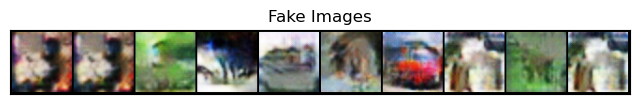


Starting Epoch [11/50]
[Epoch 11/50] Batch 0/938 | Loss_D: 0.6252 | Loss_G: 11.3508
[Epoch 11/50] Batch 100/938 | Loss_D: 0.4661 | Loss_G: 12.5972
[Epoch 11/50] Batch 200/938 | Loss_D: 0.5840 | Loss_G: 10.7120
[Epoch 11/50] Batch 300/938 | Loss_D: 0.9813 | Loss_G: 8.6487
[Epoch 11/50] Batch 400/938 | Loss_D: 0.4683 | Loss_G: 9.4430
[Epoch 11/50] Batch 500/938 | Loss_D: 0.5960 | Loss_G: 12.6917
[Epoch 11/50] Batch 600/938 | Loss_D: 0.5091 | Loss_G: 9.1739
[Epoch 11/50] Batch 700/938 | Loss_D: 0.4317 | Loss_G: 7.9889
[Epoch 11/50] Batch 800/938 | Loss_D: 0.5577 | Loss_G: 12.2993
[Epoch 11/50] Batch 900/938 | Loss_D: 0.9630 | Loss_G: 25.6168
[Epoch 11/50] Finished | Loss_D: 0.8301 | Loss_G: 13.4560

Starting Epoch [12/50]
[Epoch 12/50] Batch 0/938 | Loss_D: 0.5394 | Loss_G: 7.4748
[Epoch 12/50] Batch 100/938 | Loss_D: 0.3944 | Loss_G: 10.8507
[Epoch 12/50] Batch 200/938 | Loss_D: 0.6684 | Loss_G: 13.0878
[Epoch 12/50] Batch 300/938 | Loss_D: 0.3971 | Loss_G: 9.0629
[Epoch 12/50] Batch 40

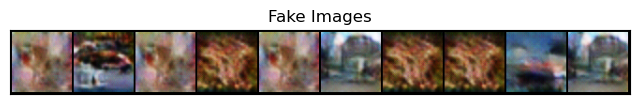


Starting Epoch [21/50]
[Epoch 21/50] Batch 0/938 | Loss_D: 0.2921 | Loss_G: 8.4182
[Epoch 21/50] Batch 100/938 | Loss_D: 0.8488 | Loss_G: 12.6110
[Epoch 21/50] Batch 200/938 | Loss_D: 0.2976 | Loss_G: 10.9420
[Epoch 21/50] Batch 300/938 | Loss_D: 0.4238 | Loss_G: 9.5844
[Epoch 21/50] Batch 400/938 | Loss_D: 0.3123 | Loss_G: 14.3755
[Epoch 21/50] Batch 500/938 | Loss_D: 0.2843 | Loss_G: 16.0272
[Epoch 21/50] Batch 600/938 | Loss_D: 0.3197 | Loss_G: 12.4409
[Epoch 21/50] Batch 700/938 | Loss_D: 0.5165 | Loss_G: 12.8310
[Epoch 21/50] Batch 800/938 | Loss_D: 0.4236 | Loss_G: 18.0822
[Epoch 21/50] Batch 900/938 | Loss_D: 0.3302 | Loss_G: 10.3538
[Epoch 21/50] Finished | Loss_D: 0.3926 | Loss_G: 13.3965

Starting Epoch [22/50]
[Epoch 22/50] Batch 0/938 | Loss_D: 0.2486 | Loss_G: 14.5382
[Epoch 22/50] Batch 100/938 | Loss_D: 0.3630 | Loss_G: 10.8635
[Epoch 22/50] Batch 200/938 | Loss_D: 0.5936 | Loss_G: 11.5216
[Epoch 22/50] Batch 300/938 | Loss_D: 0.6841 | Loss_G: 18.8558
[Epoch 22/50] Batc

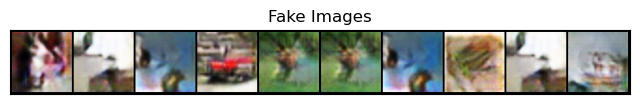


Starting Epoch [31/50]
[Epoch 31/50] Batch 0/938 | Loss_D: 0.3589 | Loss_G: 15.2933
[Epoch 31/50] Batch 100/938 | Loss_D: 0.3018 | Loss_G: 12.2867
[Epoch 31/50] Batch 200/938 | Loss_D: 0.2612 | Loss_G: 21.0837
[Epoch 31/50] Batch 300/938 | Loss_D: 0.4816 | Loss_G: 11.5604
[Epoch 31/50] Batch 400/938 | Loss_D: 0.2320 | Loss_G: 16.1749
[Epoch 31/50] Batch 500/938 | Loss_D: 0.2246 | Loss_G: 11.2797
[Epoch 31/50] Batch 600/938 | Loss_D: 0.4899 | Loss_G: 11.8170
[Epoch 31/50] Batch 700/938 | Loss_D: 0.2756 | Loss_G: 8.3829
[Epoch 31/50] Batch 800/938 | Loss_D: 0.2913 | Loss_G: 10.1494
[Epoch 31/50] Batch 900/938 | Loss_D: 0.1564 | Loss_G: 29.3595
[Epoch 31/50] Finished | Loss_D: 0.3522 | Loss_G: 15.3226

Starting Epoch [32/50]
[Epoch 32/50] Batch 0/938 | Loss_D: 0.4121 | Loss_G: 13.9124
[Epoch 32/50] Batch 100/938 | Loss_D: 0.4171 | Loss_G: 10.1503
[Epoch 32/50] Batch 200/938 | Loss_D: 0.8720 | Loss_G: 33.8190
[Epoch 32/50] Batch 300/938 | Loss_D: 0.3388 | Loss_G: 10.1818
[Epoch 32/50] Bat

KeyboardInterrupt: 

In [21]:
img_list = []
GEN_LOSS = []
DISC_LOSS = []
FID_score = []

for epoch in range(1, EPOCHS + 1):
    print(f"\nStarting Epoch [{epoch}/{EPOCHS}]")
    DiscModel.train()
    GenModel.train()
    
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        img_labels = labels.to(device)
        mb_size = images.size(0)
        fake_class_labels = 10 * torch.ones((mb_size,), dtype=torch.long, device=device)
        
        # TRAIN DISCRIMINATOR
        disc_optim.zero_grad()
        
        # Train with real images
        val_label = torch.full((mb_size,), 1.0, dtype=torch.float).to(device)
        disc_real, disc_label = DiscModel(images)
        discRealVal_Loss = criterion(disc_real, val_label)
        discRealLabel_Loss = F.nll_loss(disc_label, img_labels)
        discReal_Loss = discRealVal_Loss + discRealLabel_Loss
        discReal_Loss.backward()

        # Train with fake images
        samplelabels = torch.randint(0, 10, (mb_size,), dtype=torch.long, device=device)
        noise = torch.randn(mb_size, Z_DIM, 1, 1).to(device)
        fake = GenModel(noise, samplelabels)
        disc_fake, disc_label = DiscModel(fake.detach())
        val_label.fill_(0.0)
        discfakeVal_Loss = criterion(disc_fake, val_label)
        discFakelLabel_Loss = F.nll_loss(disc_label, fake_class_labels)
        discFake_Loss = discfakeVal_Loss + discFakelLabel_Loss
        discFake_Loss.backward()
        
        # Compute average discriminator loss
        disc_Loss = (discReal_Loss + discFake_Loss) / 2
        disc_optim.step()

        # TRAIN GENERATOR
        gen_optim.zero_grad()
        val_label.fill_(1.0)
        fake = GenModel(noise, samplelabels)
        output, output_label = DiscModel(fake)
        genVal_Loss = criterion(output, val_label)
        genLabel_Loss = F.nll_loss(output_label, samplelabels)
        gen_Loss = genVal_Loss + genLabel_Loss
        gen_Loss.backward()
        gen_optim.step()
        
        # Save losses for plotting
        GEN_LOSS.append(gen_Loss.item())
        DISC_LOSS.append(disc_Loss.item())

        # Print batch progress
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{EPOCHS}] Batch {i}/{len(trainloader)} | Loss_D: {disc_Loss.item():.4f} | Loss_G: {gen_Loss.item():.4f}")

    with torch.no_grad():
        GenModel.eval()
        gen_images = GenModel(noise, samplelabels).detach()
    img_list.append(vutils.make_grid(gen_images, padding=2, normalize=True))
    
    vutils.save_image(images.cpu(), f'Images/acganimages/real/image{epoch}.png', nrow=10, normalize=True)
    vutils.save_image(gen_images.cpu(), f'Images/acganimages/fake/image{epoch}.png', nrow=10, normalize=True)
    
    # Epoch-level progress
    print(f"[Epoch {epoch}/{EPOCHS}] Finished | Loss_D: {disc_Loss.item():.4f} | Loss_G: {gen_Loss.item():.4f}")
    
    if epoch % 10 == 0:
        imshow(gen_images[:10].cpu(), 'Fake Images', figsize=(8, 8), nrow=10)

# Save final images
print("Saving final images...")
vutils.save_image(gen_images[:10].cpu(), 'Images/acganimage10.png', nrow=10)
vutils.save_image(gen_images[:24].cpu(), 'Images/acganimage.png')
vutils.save_image(gen_images[:10].cpu(), 'Images/acganimage10norm.png', nrow=10, normalize=True)
vutils.save_image(gen_images[:24].cpu(), 'Images/acganimagenorm.png', normalize=True)

# Save model
print("Saving the model...")
torch.save(GenModel, 'Models/acgan.pth')

# Save losses
print("Saving losses...")
losses = {'GenLoss': GEN_LOSS, 'DiscLoss': DISC_LOSS}
with open('pickle/acgan_loss.txt', 'wb') as f:
    pickle.dump(losses, f)

# Save generated images for visualization
print("Saving generated images for visualization...")
with open('pickle/acganImg.txt', 'wb') as f:
    pickle.dump(img_list, f)

print("Training complete!")


Plot of the Loss

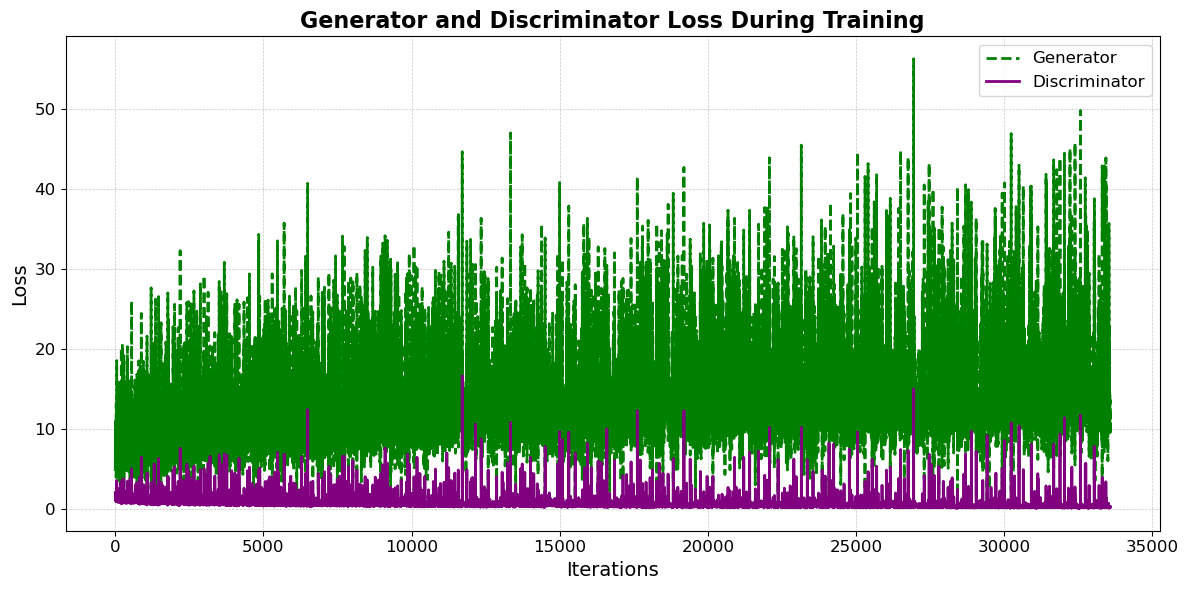

In [22]:
plt.figure(figsize=(12, 6))  # Slightly wider for better visibility
plt.title("Generator and Discriminator Loss During Training", fontsize=16, fontweight='bold')
plt.plot(GEN_LOSS, label="Generator", color='green', linewidth=2, linestyle='--')
plt.plot(DISC_LOSS, label="Discriminator", color='purple', linewidth=2, linestyle='-')
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

Calculate FID Scores

/home/shwetha/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shwetha/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


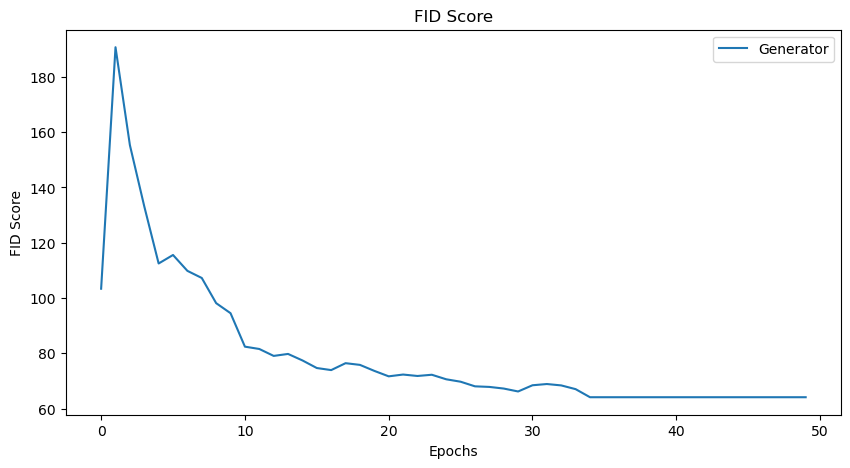

In [23]:
from FID import fidScore
acgan_FID = []
for i in range(50):
    i = i+1
    fids = fidScore('Images/acganimages/real', 'Images/acganimages/fake',i,64)
    print(f'Epoch:{i} and FID Score: {fids}', end = '\r', flush=True)
    acgan_FID.append(fids)
    
#save fid score list to file
with open('pickle/acganfid.txt', 'wb') as f:
    pickle.dump(acgan_FID,f)
    
plt.figure(figsize=(10,5))
plt.title("FID Score")
plt.plot(acgan_FID,label="Generator")
plt.xlabel("Epochs")
plt.ylabel("FID Score")
plt.legend()
plt.show()

Visualize images generated at every epoch

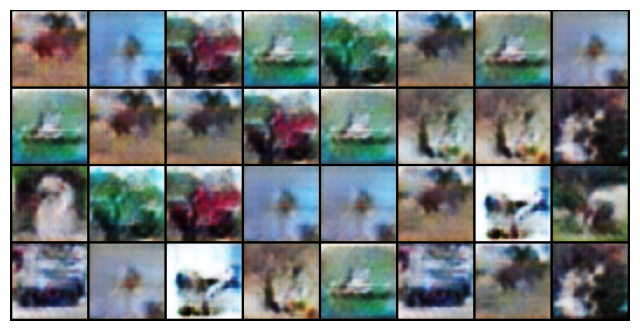

In [24]:
#%%capture
plt.rcParams['animation.embed_limit'] = 50 
with open('pickle/acganImg.txt', 'rb') as f:
    image_list = pickle.load(f)

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in image_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())